In [1]:
import numpy as np
train_file = '../pos-data/train_set.npy'
test_file = '../pos-data/test_set.npy'
vocab_file = '../pos-data/vocab.txt'
tagset_file = '../pos-data/tagset.txt'

In [2]:
train_data = np.load(train_file)
test_data = np.load(test_file)
vocabs = {}
num = 0
with open(vocab_file, 'r') as f: 
    for vocab in f.readlines():
        raw_vocab = vocab.strip()
        vocabs[raw_vocab] = num
        num += 1
tags = {}
num = 0
with open(tagset_file, 'r') as f:
    for tag in f.readlines():
        raw_tag = tag.strip()
        tags[raw_tag] = num
        num += 1

def preprocess(train_data):
    processed_data = []
    for sentence in train_data:
        processed_sen = []
        for word in sentence:
            tag = tags[word[1]]
            observe = vocabs[word[0]]
            processed_sen.append((observe, tag))
        processed_data.append(processed_sen)
    return processed_data

In [3]:
processed_train_data = preprocess(train_data)

In [4]:
tags_num = len(tags)
vocabs_num = len(vocabs)
transition_matrix = np.zeros((tags_num, tags_num))
emit_matrix = np.ones((tags_num, vocabs_num)) * 0.01
init_state_matrix = np.zeros(tags_num)

In [5]:
for sentence in processed_train_data:
    init_state_matrix[sentence[0][1]] += 1
    for i in range(len(sentence)):
        word = sentence[i]
        emit_matrix[word[1]][word[0]] += 1
        if i != (len(sentence) - 1):
            next_tag = sentence[i+1][1]
            transition_matrix[word[1]][next_tag] += 1

In [6]:
emit_matrix = emit_matrix / np.sum(emit_matrix, axis=1, keepdims=True)
transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
init_state_matrix = init_state_matrix / np.sum(init_state_matrix)

In [7]:
transition_matrix

array([[1.02232855e-01, 4.59330144e-02, 7.08133971e-02, 5.47049442e-02,
        5.98086124e-02, 1.41626794e-01, 1.85645933e-01, 1.15470494e-01,
        6.23604466e-02, 3.34928230e-03, 1.31100478e-01, 2.69537480e-02],
       [6.45286686e-02, 6.70553936e-02, 7.81341108e-02, 4.47035957e-03,
        1.76870748e-02, 5.05344995e-03, 6.97376093e-01, 2.11856171e-02,
        5.83090379e-04, 1.04956268e-02, 1.28279883e-02, 2.06025267e-02],
       [3.93079761e-02, 1.07747106e-01, 1.70461773e-02, 1.27210279e-02,
        6.36051393e-04, 3.23877369e-01, 3.23750159e-01, 6.38595599e-02,
        6.60221346e-02, 1.27210279e-03, 8.65029894e-03, 3.51100369e-02],
       [1.37701059e-01, 1.30639466e-01, 1.20047077e-01, 8.04236956e-02,
        7.84621420e-03, 6.66928207e-02, 3.13848568e-02, 2.86386818e-02,
        1.45154963e-02, 1.33385641e-02, 3.47587289e-01, 2.11847783e-02],
       [3.10765816e-02, 1.17647059e-01, 5.43840178e-02, 5.82685905e-02,
        5.54938957e-04, 1.09877913e-01, 3.55160932e-01, 4.16

In [8]:
emit_matrix

array([[4.10926208e-01, 1.05284436e-06, 3.22592566e-01, ...,
        1.05284436e-06, 1.05284436e-06, 1.05284436e-06],
       [1.89786452e-06, 3.81470769e-04, 1.89786452e-06, ...,
        1.89786452e-06, 1.89786452e-06, 1.89786452e-06],
       [1.25155192e-06, 1.25155192e-06, 1.25155192e-06, ...,
        1.25155192e-06, 1.25155192e-06, 1.25155192e-06],
       ...,
       [3.70633932e-06, 3.70633932e-06, 3.70633932e-06, ...,
        3.70633932e-06, 3.70633932e-06, 3.70633932e-06],
       [9.14320824e-07, 9.14320824e-07, 9.14320824e-07, ...,
        9.14320824e-07, 9.14320824e-07, 9.14320824e-07],
       [1.85836301e-06, 1.85836301e-06, 1.85836301e-06, ...,
        1.85836301e-06, 1.85836301e-06, 1.85836301e-06]])

In [9]:
init_state_matrix.shape

(12,)

In [10]:
def log_sum_exp(X):
    max_num = np.max(X, axis=0)
    return max_num + np.log(np.sum(np.exp(X - max_num), axis=0))

def forward(sentence):
    log_pi = np.log(init_state_matrix)
    log_E = np.log(emit_matrix)
    log_tran = np.log(transition_matrix)

    alpha = log_pi + log_E[:, sentence[0][0]]
    for i in range(1, len(sentence)):
        alpha = log_sum_exp(log_tran + np.expand_dims(alpha, axis=1) + np.expand_dims(log_E[:,sentence[i][0]], axis=0))
    return log_sum_exp(alpha)

In [11]:
negative_log = []
for sentence in processed_train_data:
    alpha = forward(sentence)
    negative_log.append(alpha)
print(-np.mean(negative_log))

169.4387479584893


In [12]:
processed_test_data = preprocess(test_data)
def predict_y(sentence):
    predict = []
    labels = []
    alpha = np.zeros((len(sentence), tags_num))
    alpha[0,:] = init_state_matrix * emit_matrix[:, sentence[0][0]]
    alpha_sum = np.sum(alpha[0,:])
    alpha[0,:] = alpha[0,:] / alpha_sum
    predict.append(np.argmax(alpha[0,:]))
    labels.append(sentence[0][1])
    for i in range(1, len(sentence)):
        alpha[i,:] = np.dot(alpha[i-1,:], transition_matrix) * emit_matrix[:, sentence[i][0]]
        alpha_sum = np.sum(alpha[i,:])
        alpha[i,:] = alpha[i,:] / alpha_sum
        predict.append(np.argmax(alpha[i,:]))
        labels.append(sentence[i][1])
    return predict, labels

In [13]:
predict = []
labels = []
for sentence in processed_test_data:
    p,l = predict_y(sentence)
    predict.extend(p)
    labels.extend(l)
predict = np.array(predict)
labels = np.array(labels)
acc = sum(predict == labels) / len(labels)

In [14]:
acc

0.9155109668535458

In [15]:
def viterbi(sentence):
    V = np.zeros((len(sentence), tags_num, 2))
    labels = []
    V[0,:,0] = init_state_matrix * emit_matrix[:, sentence[0][0]]
    V[0,:,1] = np.ones(tags_num) * -1
    labels.append(sentence[0][1])

    for t in range(1, len(sentence)):
        labels.append(sentence[t][1])
        for i in range(tags_num):
            max_pro = V[t-1, 0, 0] * transition_matrix[0][i] * emit_matrix[i][sentence[t][0]]
            pre_max_index = 0
            for pre_index in range(1, tags_num):
                prob = V[t - 1, pre_index, 0] * transition_matrix[pre_index][i] * emit_matrix[i][sentence[t][0]]
                if prob > max_pro:
                    pre_max_index = pre_index
                    max_pro = prob

            pro = max_pro
            V[t,i,:] = [pro, pre_max_index]
    
    opt = []    
    max_pro = max(V[-1,:,0])
    previous = int(V[-1,np.argmax(V[-1,:,0]),1])
    opt.append(np.argmax(V[-1,:,0]))


    for t in range(len(sentence) - 2, -1, -1):
        opt.insert(0, int(V[t+1,previous,1]))
        previous = int(V[t+1,previous,1])
    return opt, labels

test_data = np.load(test_file)
processed_test_data = preprocess(test_data)
predict = []
labels = []
for sentence in processed_test_data:
    p,l = viterbi(sentence)
    predict.extend(p)
    labels.extend(l)
predict = np.array(predict)
labels = np.array(labels)
acc = sum(predict == labels) / len(labels)
print(acc)

0.925592603521196


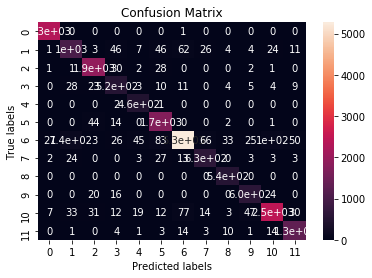

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
cm = confusion_matrix(labels, predict)
ax = plt.subplot()
import seaborn as sn
sn.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.yaxis.set_ticklabels(['health', 'business']);
